## Imports

In [2]:
import os
import numpy as np
import torch
import albumentations as A
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as cp
import cv2

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from albumentations.pytorch.transforms import ToTensorV2
from PIL import Image
from matplotlib import pyplot as plt

## Dataset

In [46]:
color_map = [1, 2, 3] #[outline, background, ground_truth, object(cat or dog)]

In [3]:
train_transform = A.Compose(
    [
        A.Resize(width=130, height=130),
        A.RandomCrop(width=128, height=128),
        A.RandomRotate90(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.3),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.OneOf([
            A.Blur(blur_limit=3, p=0.5),
            A.ColorJitter(p=0.5),
        ], p=1.0),
        A.Normalize(
            mean=[0, 0, 0],
            std=[1, 1, 1],
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

In [4]:
val_transform = A.Compose(
        [
            A.Resize(width=130, height=130),
            A.CenterCrop(width=128, height=128),
            A.Normalize(
                mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

In [118]:
def process_mask(mask, colormap, class_name):
    output_mask = []
    mask = np.array(mask)

    for color in colormap:
        cmap = np.all(np.equal(mask, color), axis=-1)
        output_mask.append(cmap)

    # To add a mask for class that have no value in image
    extra_mask = np.zeros((128, 128)) 

    if class_name == "dog":
        output_mask.insert(2, extra_mask)    

    else:
        output_mask.append(extra_mask)
           
    output_mask = np.stack(output_mask, axis=-1)
    
    output_mask = torch.tensor(output_mask).float().permute(2, 0, 1)
    
    return output_mask

In [119]:
class CarvanaDataset(Dataset):
    
    def __init__(self, image_dir, mask_dir, color_map, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        self.color_map = color_map

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", ".png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)
        mask = np.expand_dims(mask, axis=-1)

        if self.images[index][0].isupper():
            class_name = 'cat'
        
        else:
            class_name = 'dog'

        if self.transform is not None:   
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]
            mask = process_mask(mask, self.color_map, class_name)      
    
        return image, mask

In [120]:
image_dir = 'data/images/'
mask_dir = 'data/annotations/trimaps/'

In [121]:
train_dataset = CarvanaDataset(image_dir, mask_dir, transform=train_transform, color_map=color_map)
valid_dataset = CarvanaDataset(image_dir, mask_dir, transform=val_transform, color_map=color_map)

In [122]:
train_loader = DataLoader(dataset=train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=8, shuffle=True)

In [142]:
print(train_dataset[500][0].shape)
print(train_dataset[500][1].shape)

dog
torch.Size([4, 128, 128])
torch.Size([3, 128, 128])
dog
torch.Size([4, 128, 128])
torch.Size([4, 128, 128])


[1 2 3]


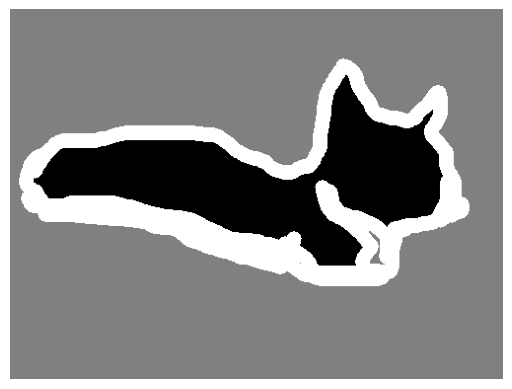

In [125]:
# Load a grayscale image using OpenCV
image = cv2.imread('data/annotations/trimaps/Bengal_10.png', cv2.IMREAD_GRAYSCALE)
print(np.unique(image))

# Display the grayscale image using matplotlib
plt.imshow(image, cmap='gray')
plt.axis('off')  # Optionally, turn off axis labels
plt.show()